## Generate pie charts function with annotation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import colorsys
import json
import chardet

def read_csv_with_encoding(file_path, header=None):
    """
    Membaca file CSV dengan deteksi encoding otomatis.
    """
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    encoding = result['encoding']
    try:
        return pd.read_csv(file_path, encoding=encoding, header=header)
    except Exception as e:
        raise ValueError(f"Gagal membaca file {file_path} dengan encoding {encoding}: {e}")

def generate_random_colors(n):
    """Generate n distinct colors"""
    colors = []
    for i in range(n):
        hue = i/n
        saturation = 0.7 + random.random() * 0.3
        value = 0.8 + random.random() * 0.2
        colors.append(colorsys.hsv_to_rgb(hue, saturation, value))
    return colors

def convert_to_number(x):
    """Convert string to appropriate number type (int or float)"""
    if x == '-' or x == '' or x.isspace():
        return None
    try:
        num = float(x)
        return int(num) if num.is_integer() else num
    except (ValueError, TypeError):
        return None

def format_value(value):
    if value is None:
        return ""
    if np.issubdtype(type(value), np.integer):
        return f"{value:,}"
    elif np.issubdtype(type(value), np.floating):
        return f"{value:,.2f}"
    return str(value)

def make_autopct(values):
    """
    Mengembalikan fungsi autopct yang akan mengambil nilai dari iterator
    sehingga untuk setiap segmen, nilai yang diformat adalah nilai asli sesuai urutan.
    """
    it = iter(values)
    def inner(pct):
        value = next(it)
        if abs(value - round(value)) < 1e-6:
            return f"{int(round(value)):,}"
        else:
            return f"{value:,.2f}"
    return inner

def convert_numpy_types(obj):
    """Convert numpy types to native Python types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(v) for v in obj]
    return obj

def extract_annotations(fig, ax, wedges, texts, values, categories):
    """
    Mengekstrak anotasi dari figure pie chart.
    
    Menghasilkan dictionary dengan format:
      {
         "models": [ {name, color, bbox, value, text_label, text_bbox, points}, ... ],
         "type": "pie",
         "general_figure_info": {
              "title": {"text": <judul>, "bbox": <bounding_box>},
              "x_axis": [], 
              "y_axis": [],
              "legend": { "texts": [..], "bbox": <bounding_box> },
              "figure_info": <bounding_box>
         }
      }
    """
    renderer = fig.canvas.get_renderer()
    # Ekstrak informasi judul
    title_text = ax.get_title()
    title_obj = ax.title
    title_bbox = title_obj.get_window_extent(renderer=renderer).bounds if title_obj is not None else None
    # Bounding box dari area plot (axes)
    figure_bbox = ax.get_window_extent(renderer=renderer).bounds
    # Untuk pie chart, sumbu X dan Y biasanya kosong
    general_info = {
        "title": {"text": title_text, "bbox": title_bbox},
        "x_axis": [],
        "y_axis": [],
        "legend": {},
        "figure_info": figure_bbox
    }
    # Jika ada legend, ambil informasinya
    leg = ax.get_legend()
    if leg is not None:
        legend_bbox = leg.get_window_extent(renderer=renderer).bounds
        legend_texts = [t.get_text() for t in leg.get_texts()]
        general_info["legend"] = {"texts": legend_texts, "bbox": legend_bbox}
    
    models = []
    for wedge, text, val, cat in zip(wedges, texts, values, categories):
        # Dapatkan bounding box untuk wedge dalam koordinat display
        bbox_data = wedge.get_path().get_extents()
        bbox_disp = wedge.get_transform().transform_bbox(bbox_data).bounds
        # Dapatkan warna slice (RGBA)
        color = wedge.get_facecolor()
        # Jika teks kosong, gunakan nama kategori
        text_label = text.get_text() if text.get_text() != "" else cat
        text_bbox = text.get_window_extent(renderer=renderer).bounds
        # Hitung titik-titik penting: center, start dan end (menggunakan atribut wedge)
        center = wedge.center
        r = wedge.r
        theta1 = np.deg2rad(wedge.theta1)
        theta2 = np.deg2rad(wedge.theta2)
        start_point = (center[0] + r * np.cos(theta1), center[1] + r * np.sin(theta1))
        end_point = (center[0] + r * np.cos(theta2), center[1] + r * np.sin(theta2))
        points = {"center": center, "start": start_point, "end": end_point}
        model = {
            "name": cat,
            "color": color,
            "bbox": bbox_disp,
            "value": val,
            "text_label": text_label,
            "text_bbox": text_bbox,
            "points": points
        }
        models.append(model)
        
    return {"models": models, "type": "pie", "general_figure_info": general_info}

def generate_multi_style_piecharts(csv_path, metadata_path, output_image_dir=None, output_info_dir=None):
    """
    Membuat pie chart dengan berbagai style dari data tabel dan menyimpan informasi anotasinya.
    
    Selain menyimpan gambar, fungsi ini juga membuat file JSON yang menyimpan:
      - models: list anotasi untuk tiap segmen pie chart.
      - type: jenis chart (pie).
      - general_figure_info: informasi umum seperti judul, sumbu, legenda, dan bounding box plot.
    """
    if output_image_dir is None:
        output_image_dir = os.path.dirname(csv_path)
    if output_info_dir is None:
        output_info_dir = os.path.dirname(csv_path)

    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_info_dir, exist_ok=True)

    # Baca metadata dan ambil informasi chart
    metadata_df = read_csv_with_encoding(metadata_path, header=0)
    table_id = os.path.splitext(os.path.basename(csv_path))[0]
    metadata_row = metadata_df[metadata_df['Table ID'] == table_id]
    if metadata_row.empty:
        print(f"Metadata untuk Table ID {table_id} tidak ditemukan. Melewati file ini.")
        return None
    
    judul = metadata_row['Judul Tabel'].values[0]
    tahun = metadata_row['Tahun'].values[0]
    title = f"{judul} Tahun {tahun}"
    is_pie = metadata_row['is_pie'].values[0]
    if is_pie.lower() != 'yes':
        print(f"Pie chart untuk Table ID {table_id} tidak diperlukan (is_pie = 'no'). Melewati file ini.")
        return None

    # Baca data tabel CSV
    df = read_csv_with_encoding(csv_path, header=None)
    data = df.iloc[1:-1]
    data_dict = {}
    no_data_categories = []
    for idx, row in data.iterrows():
        category = row[0]
        value = convert_to_number(row[1])
        if value is None:
            no_data_categories.append(category)
        else:
            data_dict[category] = value

    categories = list(data_dict.keys())
    values = list(data_dict.values())
    if not values:
        print(f"Tidak ada data yang valid untuk Table ID {table_id}. Melewati file ini.")
        return None

    highest_value = max(values)
    lowest_value = min(values)
    highest_category = categories[values.index(highest_value)]
    lowest_category = categories[values.index(lowest_value)]
    
    base_filename = os.path.splitext(os.path.basename(csv_path))[0]
    image_paths = {
        'a': os.path.join(output_image_dir, f"{base_filename}_pie_a.png"),
        'b': os.path.join(output_image_dir, f"{base_filename}_pie_b.png"),
        'c': os.path.join(output_image_dir, f"{base_filename}_pie_c.png"),
        'd': os.path.join(output_image_dir, f"{base_filename}_pie_d.png"),
        'e': os.path.join(output_image_dir, f"{base_filename}_pie_e.png")
    }
    info_path = os.path.join(output_info_dir, f"{base_filename}_chart_info.json")

    chart_info = {
        'title': title,
        'data': data_dict,
        'no_data_categories': no_data_categories,
        'total': sum(values),
        'num_categories': len(categories),
        'highest': {'category': highest_category, 'value': highest_value},
        'lowest': {'category': lowest_category, 'value': lowest_value}
    }

    def add_no_data_note(fig, title, no_data_categories):
        if no_data_categories:
            note_text = "No data available for: " + ", ".join(no_data_categories)
            fig.text(0.5, 0.02, note_text, ha='center', va='center', 
                     fontsize=10, style='italic', color='gray', wrap=True)
            plt.subplots_adjust(bottom=0.15)
        plt.title(title, pad=20, wrap=True)

    styles_info = {}

    # ================= Style A: Basic pie with values =================
    style_a_info = chart_info.copy()
    fig = plt.figure(figsize=(12, 8))
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(categories)))
    wedges, texts, autotexts = plt.pie(values, labels=categories, autopct=make_autopct(values.copy()),
                                       colors=colors)
    add_no_data_note(fig, title, no_data_categories)
    plt.axis('equal')
    ax = plt.gca()
    fig.canvas.draw()
    annotations = extract_annotations(fig, ax, wedges, texts, values, categories)
    style_a_info["annotations"] = annotations
    plt.savefig(image_paths['a'], dpi=300, bbox_inches='tight')
    plt.close()
    styles_info['style_a'] = style_a_info

    # ================= Style B: Modern donut with values =================
    style_b_info = chart_info.copy()
    fig = plt.figure(figsize=(12, 8))
    colors = generate_random_colors(len(categories))
    wedges, texts, autotexts = plt.pie(values, labels=categories, colors=colors, startangle=90,
                                       wedgeprops=dict(width=0.75),
                                       autopct=make_autopct(values.copy()))
    add_no_data_note(fig, title, no_data_categories)
    plt.axis('equal')
    ax = plt.gca()
    fig.canvas.draw()
    annotations = extract_annotations(fig, ax, wedges, texts, values, categories)
    style_b_info["annotations"] = annotations
    plt.savefig(image_paths['b'], dpi=300, bbox_inches='tight')
    plt.close()
    styles_info['style_b'] = style_b_info

    # ================= Style C: Dark theme pie with values =================
    style_c_info = chart_info.copy()
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 8))
    explode = [0.05] * len(categories)
    wedges, texts, autotexts = plt.pie(values, labels=categories, explode=explode,
                                       autopct=make_autopct(values.copy()),
                                       colors=plt.cm.Dark2(np.linspace(0, 1, len(categories))),
                                       startangle=180)
    add_no_data_note(fig, title, no_data_categories)
    plt.axis('equal')
    ax = plt.gca()
    fig.canvas.draw()
    annotations = extract_annotations(fig, ax, wedges, texts, values, categories)
    style_c_info["annotations"] = annotations
    plt.savefig(image_paths['c'], dpi=300, bbox_inches='tight',
                facecolor='black', edgecolor='none')
    plt.close()
    plt.style.use('default')
    styles_info['style_c'] = style_c_info

    # ================= Style D: Detailed legend with values =================
    style_d_info = chart_info.copy()
    
    # 1. Gunakan GridSpec untuk membagi figure menjadi 2 kolom dengan rasio 3:1
    fig = plt.figure(figsize=(12, 8))
    gs = plt.GridSpec(1, 2, width_ratios=[3, 1])  # 1 baris, 2 kolom (rasio 3:1)
    
    # 2. Plot pie chart di subplot pertama (kolom 0)
    ax = plt.subplot(gs[0])
    base_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']
    colors_d = base_colors[:len(categories)]
    patches, texts = ax.pie(values, labels=categories, colors=colors_d, startangle=270,
                            wedgeprops={'linewidth': 1.5, 'edgecolor': 'white',
                                        'width': 0.75, 'alpha': 0.9})
    
    # 3. Tambahkan legenda di subplot kedua (kolom 1) yang kosong
    labels = [f'{cat}\n{format_value(val)}' for cat, val in zip(categories, values)]
    ax.legend(patches, labels, title="Details", loc="center left",
              bbox_to_anchor=(1.3, 0.5),  # Posisikan di kolom 1
              borderpad=2, labelspacing=1.5)
    
    # 4. Atur layout dan simpan
    add_no_data_note(fig, title, no_data_categories)
    plt.axis('equal')

    fig.canvas.draw()
    annotations = extract_annotations(fig, ax, patches, texts, values, categories)
    style_d_info["annotations"] = annotations
    
    # Simpan dengan padding konsisten dan facecolor
    plt.savefig(image_paths['d'], dpi=300, 
               facecolor='white', edgecolor='none',
               bbox_inches='tight')
    plt.close()
    styles_info['style_d'] = style_d_info

    # ================= Style E: Modern Segmented Donut with Side Labels =================
    style_e_info = chart_info.copy()
    fig = plt.figure(figsize=(12, 8))
    base_color = plt.cm.viridis(np.linspace(0, 0.8, len(categories)))
    # Buat donut chart tanpa label langsung
    wedges, texts, autotexts = plt.pie(values, 
                                       labels=[''] * len(categories),  
                                       colors=base_color,
                                       startangle=90,
                                       wedgeprops=dict(width=0.75, edgecolor='white', linewidth=2),
                                       radius=1,
                                       autopct='')
    # Tambahkan garis penghubung dan label secara manual
    bbox_props = dict(boxstyle="round,pad=0.5", fc="w", ec="gray", alpha=0.8)
    kw = dict(arrowprops=dict(arrowstyle="-", color="gray", linewidth=1.5),
              bbox=bbox_props, zorder=0, va="center")
    # Kumpulkan objek teks dari annotate untuk keperluan ekstraksi
    annotation_texts = []
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1 + random.uniform(-2, 2)
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        label_x = 1.5 * np.sign(x)
        label_y = 1.1 * y
        label = f"{categories[i]}\n{format_value(values[i])}"
        txt = plt.annotate(label, xy=(x, y), xytext=(label_x, label_y),
                           horizontalalignment=horizontalalignment, **kw)
        annotation_texts.append(txt)
    add_no_data_note(fig, title, no_data_categories)
    plt.axis('equal')
    ax = plt.gca()
    fig.canvas.draw()
    # Gunakan annotation_texts sebagai objek teks untuk ekstraksi
    annotations = extract_annotations(fig, ax, wedges, annotation_texts, values, categories)
    style_e_info["annotations"] = annotations
    # plt.savefig(image_paths['e'], dpi=300, bbox_inches='tight')
    plt.savefig(image_paths['e'], dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    styles_info['style_e'] = style_e_info

    with open(info_path, 'w', encoding='utf-8') as f:
        json.dump(convert_numpy_types(styles_info), f, indent=4, ensure_ascii=False)

    return {
        'image_paths': image_paths,
        'info_path': info_path,
        'styles_info': styles_info
    }


## Generate sample

In [2]:
## SAMPLE USAGE
csv_file = '/kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4/T0120.csv'
metadata_file = '/kaggle/input/table-dataset/metadata_tabel.csv'
output_image_dir = '/kaggle/working/sample'
output_info_dir = '/kaggle/working/sample-info'

result = generate_multi_style_piecharts(
    csv_path=csv_file,
    metadata_path=metadata_file,
    output_image_dir=output_image_dir,
    output_info_dir=output_info_dir
)

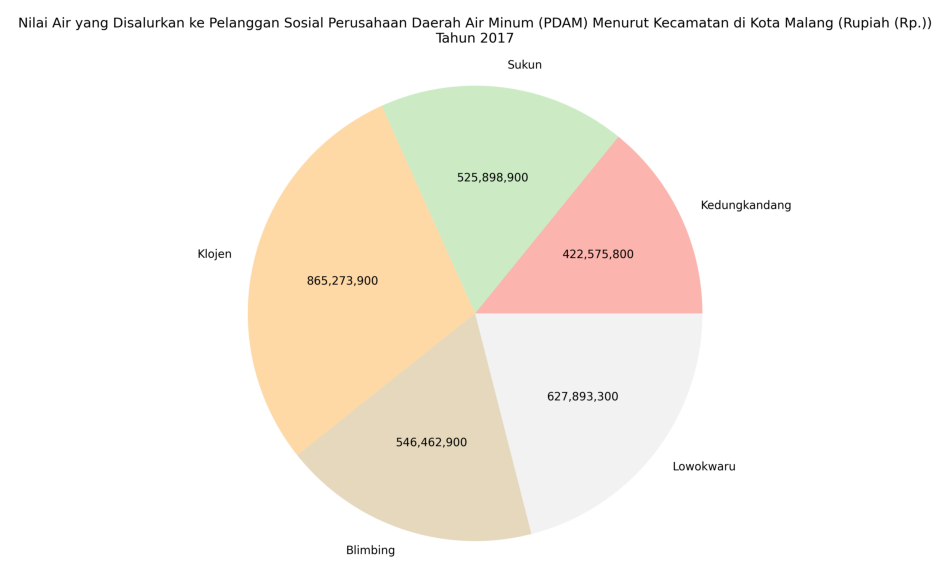

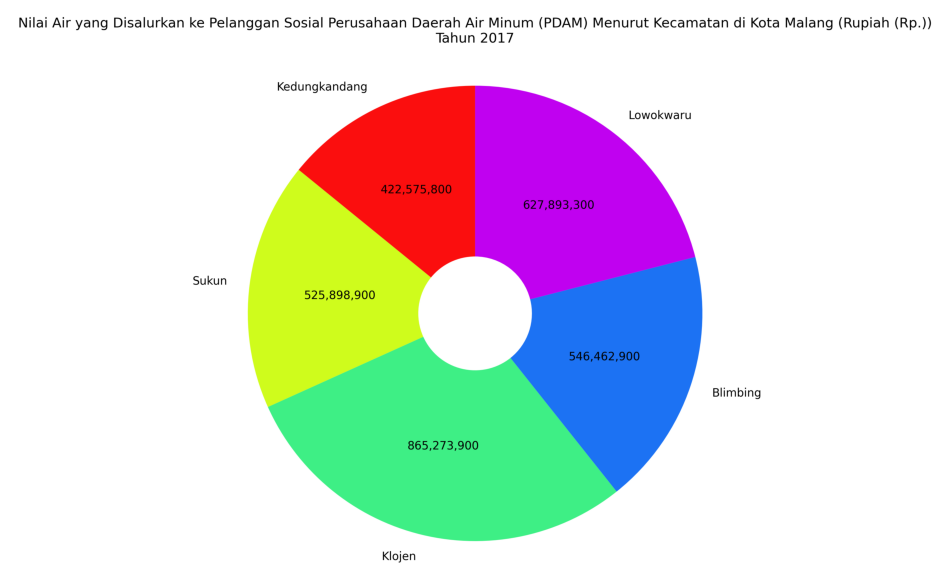

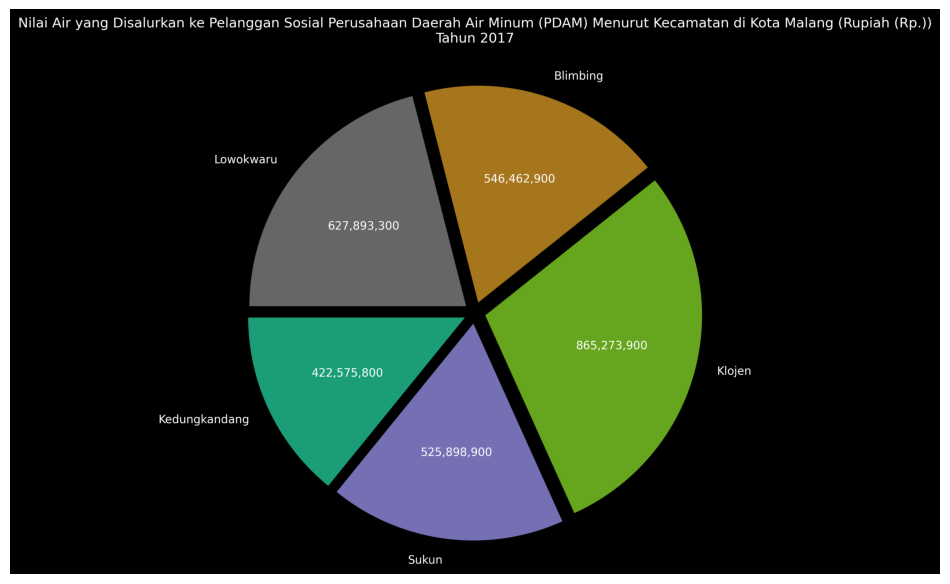

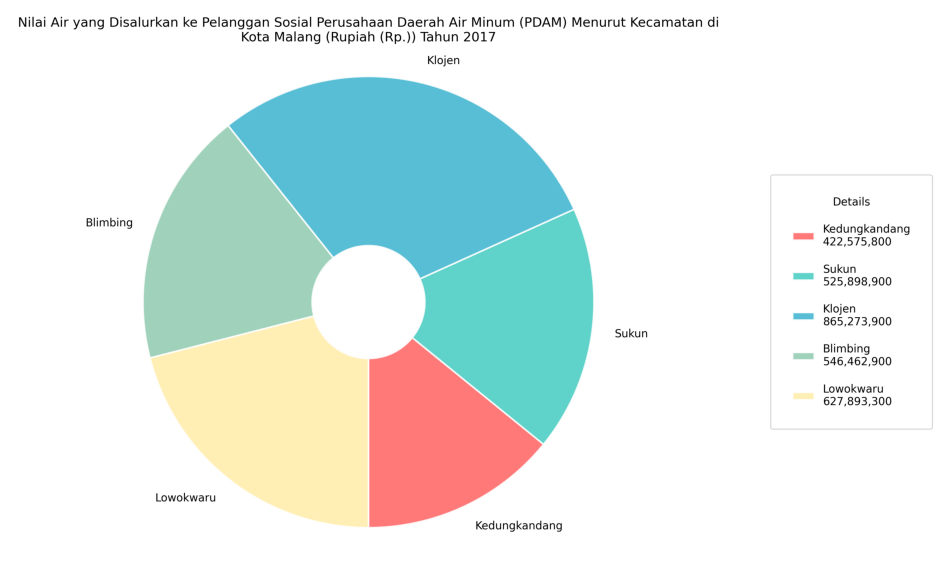

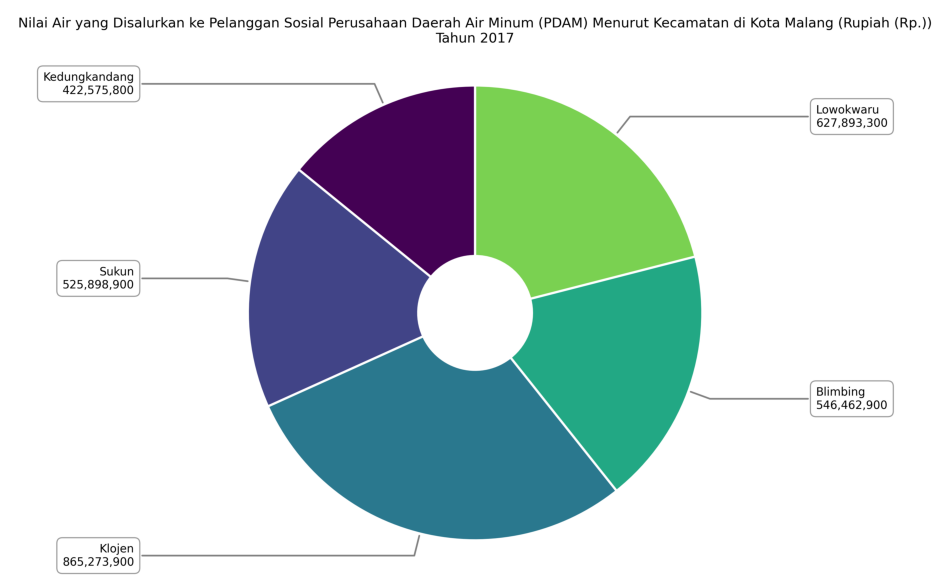

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for style, path in result['image_paths'].items():
    img = mpimg.imread(path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    # plt.title(f"Piechart - Style {style.upper()}")
    plt.show()

## Batch function

In [4]:
def generate_batch_charts(input_dir, metadata_path, output_image_dir, output_info_dir):
    """
    Generate charts for multiple CSV files in a directory

    Parameters:
    input_dir (str): Directory containing CSV files
    output_image_dir (str): Directory to save chart images
    output_info_dir (str): Directory to save chart info files

    Returns:
    dict: Summary of processed files and any errors encountered
    """
    from tqdm.notebook import tqdm

    # Ensure output directories exist
    os.makedirs(output_image_dir, exist_ok=True)
    os.makedirs(output_info_dir, exist_ok=True)

    # Get all CSV files in input directory
    print(f"Checking files in directory: {input_dir}")
    csv_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.lower().endswith('.csv')]

    # Debug: Print found files
    # print(f"Debug: Found files: {csv_files}")

    # Initialize results tracking
    results = {
        'total_files': len(csv_files),
        'processed': 0,
        'errors': [],
        'successfully_processed': []
    }

    # Process each CSV file with progress bar
    print(f"Found {len(csv_files)} CSV files to process")

    for csv_file in tqdm(csv_files, desc="Generating charts"):
        try:
            # Generate charts for current file
            result = generate_multi_style_piecharts(
                csv_path=csv_file,
                metadata_path=metadata_file,
                output_image_dir=output_image_dir,
                output_info_dir=output_info_dir
            )

            # Track successful processing
            results['processed'] += 1
            results['successfully_processed'].append(os.path.basename(csv_file))

        except Exception as e:
            # Track any errors
            error_info = {
                'file': os.path.basename(csv_file),
                'error': str(e)
            }
            results['errors'].append(error_info)

    # Print summary
    print("\nProcessing Complete!")
    print(f"Successfully processed: {results['processed']} files")
    print(f"Errors encountered: {len(results['errors'])} files")

    # If there were any errors, print them
    if results['errors']:
        print("\nErrors:")
        for error in results['errors']:
            print(f"File: {error['file']}")
            print(f"Error: {error['error']}\n")

    return results

## Generate pie-charts with batch processing

In [5]:
input_dir = '/kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4'
output_image_dir = '/kaggle/working/piechart-versi5'
output_info_dir = '/kaggle/working/piechart-info-versi5'
metadata_file = '/kaggle/input/table-dataset/metadata_tabel.csv'

# Run batch processing
batch_results = generate_batch_charts(
    input_dir=input_dir,
    metadata_path=metadata_file,
    output_image_dir=output_image_dir,
    output_info_dir=output_info_dir
)

# Optional: Save processing results to file
import json
results_file = os.path.join(output_info_dir, 'batch_processing_results.json')
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(batch_results, f, indent=4, ensure_ascii=False)

Checking files in directory: /kaggle/input/table-dataset/table-dataset-versi4/table-dataset-versi4
Found 1200 CSV files to process


Generating charts:   0%|          | 0/1200 [00:00<?, ?it/s]

Pie chart untuk Table ID T0243 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0228 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0224 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0218 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0254 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0219 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0242 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0251 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0261 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0253 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0256 tidak diperlukan (is_pie = 'no'). Melewati file ini.
Pie chart untuk Table ID T0257 tidak diperlukan (is_pie = 'no'). Melewati fi

## Save results

In [6]:
import shutil

piechart_folder = "/kaggle/working/piechart-versi5"
output_piechart = "piechart-versi5.zip"

piechart_info_folder = "/kaggle/working/piechart-info-versi5"
output_info_piechart = "piechart-info-versi5.zip"

shutil.make_archive(output_piechart.replace('.zip', ''), 'zip', piechart_folder)
shutil.make_archive(output_info_piechart.replace('.zip', ''), 'zip', piechart_info_folder)

print(f"{output_piechart} berhasil dibuat.")
print(f"{output_info_piechart} berhasil dibuat.")

piechart-versi5.zip berhasil dibuat.
piechart-info-versi5.zip berhasil dibuat.
